In [148]:
import cv2
import os
import numpy as np
import pandas as pd
import pytesseract
from pytesseract import Output
import matplotlib.pyplot as plt
pytesseract.pytesseract.tesseract_cmd="/home/aman/anaconda3/envs/tallyInvoiceParser.env/bin/tesseract"
os.environ['TESSDATA_PREFIX'] = "/home/aman/anaconda3/envs/tallyInvoiceParser.env/share/tessdata"
os.environ['MLIR_CRASH_REPRODUCER_DIRECTORY']='tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269'
import import_ipynb
from imagePreProcessor import *
import math
from sklearn.model_selection import train_test_split
import keras
from keras import models
from keras.models import Sequential
from keras.layers import Dense, ReLU, activation, Dropout
import tensorflow as tf
import datefinder
import dateparser
from IPython.display import clear_output
from sklearn.utils import shuffle

In [106]:
pwd

'/home/aman/Documents/Tally/Git-Document-AI/Document-AI/InvoiceDateModel-v2/Dataset'

In [107]:
os.chdir('/home/aman/Documents/Tally/Git-Document-AI/Document-AI/InvoiceDateModel-v2/Dataset/')

In [141]:
df = pd.read_csv("tesseract4.csv")

In [142]:
df.shape

(299, 45)

In [143]:
df.drop_duplicates(subset=["x", "y", "imageName"], keep="first", inplace=True)

In [144]:
df.shape

(195, 45)

In [145]:
df.describe()

,Unnamed: 0.1,Unnamed: 0,left,top,width,height,conf,x,y,PageHeight,...,invoice dt y,due date y,payment date y,ack date y,ack dt y,bill dt y,receipt date y,receipt dt y,imageName,output
count,195.000000,195.000000,195.000000,195.000000,195.000000,195.000000,195.000000,195.000000,195.000000,195.000000,...,195.000000,195.000000,195.000000,195.000000,195.000000,195.000000,195.000000,195.000000,195.000000,195.000000
mean,147.769231,154.112821,1203.600000,1203.687179,198.343590,32.451282,82.320841,1401.943590,1236.138462,3482.369231,...,322.912821,34.548718,6.461538,41.743590,28.276923,35.687179,4.287179,6.502564,46.471795,0.358974
std,87.624569,87.394517,735.950927,782.358165,89.033064,7.848530,20.195334,730.810341,782.563371,500.880644,...,505.365416,158.722904,63.637928,315.402616,163.894910,153.329742,59.867203,63.705376,29.175137,0.480934
min,0.000000,0.000000,75.000000,67.000000,98.000000,16.000000,0.000000,210.000000,97.000000,1566.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000
25%,71.000000,77.500000,555.500000,607.500000,156.000000,27.500000,74.643830,783.500000,635.500000,3300.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,16.500000,0.000000
50%,146.000000,155.000000,1232.000000,959.000000,182.000000,32.000000,90.819194,1415.000000,985.000000,3500.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,45.000000,0.000000
75%,222.500000,231.000000,1871.000000,1558.500000,211.000000,37.000000,96.236962,2104.500000,1598.500000,3508.000000,...,588.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,69.500000,1.000000
max,297.000000,298.000000,3130.000000,3395.000000,821.000000,71.000000,96.945030,3278.000000,3424.000000,5313.000000,...,2995.000000,1336.000000,630.000000,2571.000000,1717.000000,949.000000,836.000000,836.000000,107.000000,1.000000


In [146]:
len(df["imageName"].unique())

72

In [147]:
df.head()

,Unnamed: 0.1,Unnamed: 0,left,top,width,height,conf,text,x,y,...,invoice dt y,due date y,payment date y,ack date y,ack dt y,bill dt y,receipt date y,receipt dt y,imageName,output
0,0,72,1713,256,203,28,96.087402,21-07-2022,1916,284,...,136,0,0,0,0,0,0,0,1,1
2,2,206,1648,1936,214,31,79.921706,1-oct-22. to 31,1862,1967,...,0,0,0,0,0,0,0,0,2,0
3,3,204,1648,1936,136,31,48.239994,1-oct-22.,1784,1967,...,0,0,0,0,0,0,0,0,2,0
4,4,203,376,486,163,35,95.528168,22-sep-22,539,521,...,0,0,0,517,517,0,0,0,2,1
6,6,51,2100,779,172,37,86.337227,1-mar-23,2272,816,...,808,0,0,0,0,0,0,0,3,1


In [152]:
def preProcess(df):
    for index in df.index:
        
        x = df["x"][index]
        y = df["y"][index]
        X = df["PageWidth"][index]
        X = X/2
        Y = df["PageHeight"][index]
        Y = Y/2
        
        if x<X:
            df["isLeft"][index]=1
        elif x>=X:
            df["isRight"][index]=1
            
        if y>Y:
            df["isBottom"][index]=1
        elif y<Y:
            df["isTop"][index]=1

            
    df["x"]/=df["PageWidth"]
    df["y"]/=df["PageHeight"]

    df["conf"]/=100

    neighbourFields = ["invoice date", "invoice dt", "due date", "payment date", "ack date", "ack dt", "bill dt", "receipt date", "receipt dt"]
    
    neighbourFieldsX = ["invoice date x", "invoice dt x", "due date x", "payment date x", "ack date x", "ack dt x", "bill dt x", "receipt date x", "receipt dt x"]

    neighbourFieldsY = ["invoice date y", "invoice dt y", "due date y", "payment date y", "ack date y", "ack dt y", "bill dt y", "receipt date y", "receipt dt y"]

    for col in neighbourFieldsX:
        df[col]/=df["PageWidth"]

    for col in neighbourFieldsY:
        df[col]/=df["PageHeight"]
    
    colsToDrop = ["Unnamed: 0", "Unnamed: 0.1", "left", "top", "width", "height", "text", "PageHeight", "PageWidth", "imageName"]
    df.drop(columns=colsToDrop, inplace=True)
    

In [153]:
preProcess(df)

/tmp/ipykernel_6771/1500211779.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["isRight"][index]=1
/tmp/ipykernel_6771/1500211779.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["isTop"][index]=1
/tmp/ipykernel_6771/1500211779.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["isBottom"][index]=1
/tmp/ipykernel_6771/1500211779.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a 

In [154]:
df

,conf,x,y,isTop,isBottom,isRight,isLeft,invoice date,invoice dt,due date,...,invoice date y,invoice dt y,due date y,payment date y,ack date y,ack dt y,bill dt y,receipt date y,receipt dt y,output
0,0.960874,0.772892,0.081050,1,0,1,0,1,1,0,...,0.038813,0.038813,0.0,0.0,0.000000,0.000000,0.0,0.0,0.000000,1
2,0.799217,0.751109,0.561358,0,1,1,0,0,0,0,...,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.0,0.000000,0
3,0.482400,0.719645,0.561358,0,1,1,0,0,0,0,...,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.0,0.000000,0
4,0.955282,0.217426,0.148687,1,0,0,1,0,0,0,...,0.000000,0.000000,0.0,0.0,0.147546,0.147546,0.0,0.0,0.000000,1
6,0.863372,0.890980,0.247273,1,0,1,0,1,1,0,...,0.244848,0.244848,0.0,0.0,0.000000,0.000000,0.0,0.0,0.000000,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
291,0.960039,0.793062,0.077340,1,0,1,0,1,1,0,...,0.034247,0.034247,0.0,0.0,0.000000,0.000000,0.0,0.0,0.000000,1
293,0.959007,0.909020,0.375455,1,0,1,0,0,0,0,...,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.0,0.000000,1
295,0.962639,0.910448,0.160775,1,0,1,0,0,0,0,...,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.0,0.049886,1
296,0.577509,0.740741,0.340358,1,0,1,0,0,0,0,...,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.0,0.000000,0


In [155]:
df.describe()

,conf,x,y,isTop,isBottom,isRight,isLeft,invoice date,invoice dt,due date,...,invoice date y,invoice dt y,due date y,payment date y,ack date y,ack dt y,bill dt y,receipt date y,receipt dt y,output
count,195.000000,195.000000,195.000000,195.000000,195.000000,195.000000,195.000000,195.000000,195.000000,195.000000,...,195.000000,195.000000,195.000000,195.000000,195.000000,195.000000,195.000000,195.000000,195.000000,195.000000
mean,0.823208,0.544255,0.356838,0.774359,0.225641,0.507692,0.492308,0.307692,0.441026,0.056410,...,0.058910,0.094588,0.009957,0.001842,0.011904,0.007472,0.010695,0.001224,0.001879,0.358974
std,0.201953,0.277128,0.219835,0.419080,0.419080,0.501228,0.501228,0.462726,0.497788,0.231306,...,0.113026,0.148783,0.045927,0.018146,0.089936,0.054017,0.045997,0.017085,0.018275,0.480934
min,0.000000,0.059795,0.019529,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.746438,0.305414,0.181143,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.908192,0.503426,0.284848,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.962370,0.818442,0.474214,1.000000,0.000000,1.000000,1.000000,1.000000,1.000000,0.000000,...,0.119979,0.168000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
max,0.969450,0.941556,0.978286,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,0.853763,0.904848,0.380844,0.179641,0.733105,0.692060,0.287576,0.238584,0.238584,1.000000


In [158]:
df = shuffle(df, random_state=8)

In [159]:
df

,conf,x,y,isTop,isBottom,isRight,isLeft,invoice date,invoice dt,due date,...,invoice date y,invoice dt y,due date y,payment date y,ack date y,ack dt y,bill dt y,receipt date y,receipt dt y,output
277,0.904016,0.303529,0.239091,1,0,0,1,1,1,0,...,0.223030,0.223030,0.0,0.000000,0.0,0.00000,0.000000,0.0,0.0,1
151,0.969153,0.084094,0.970979,0,1,0,1,0,0,0,...,0.000000,0.000000,0.0,0.000000,0.0,0.00000,0.000000,0.0,0.0,0
150,0.879933,0.380844,0.692463,0,1,0,1,0,1,0,...,0.000000,0.619508,0.0,0.000000,0.0,0.69206,0.000000,0.0,0.0,0
102,0.961343,0.335294,0.746061,0,1,0,1,0,0,0,...,0.000000,0.000000,0.0,0.000000,0.0,0.00000,0.000000,0.0,0.0,0
74,0.617027,0.147984,0.437696,1,0,0,1,0,0,0,...,0.000000,0.000000,0.0,0.000000,0.0,0.00000,0.000000,0.0,0.0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
37,0.000000,0.366385,0.171086,1,0,0,1,1,1,0,...,0.169661,0.169661,0.0,0.000000,0.0,0.00000,0.000000,0.0,0.0,1
144,0.267367,0.362757,0.182207,1,0,0,1,1,1,0,...,0.153693,0.153693,0.0,0.179641,0.0,0.00000,0.000000,0.0,0.0,0
6,0.863372,0.890980,0.247273,1,0,1,0,1,1,0,...,0.244848,0.244848,0.0,0.000000,0.0,0.00000,0.000000,0.0,0.0,1
165,0.896727,0.774510,0.196364,1,0,1,0,1,1,0,...,0.195455,0.195455,0.0,0.000000,0.0,0.00000,0.178485,0.0,0.0,1


In [160]:
df.corr()

,conf,x,y,isTop,isBottom,isRight,isLeft,invoice date,invoice dt,due date,...,invoice date y,invoice dt y,due date y,payment date y,ack date y,ack dt y,bill dt y,receipt date y,receipt dt y,output
conf,1.000000,0.103808,-0.000571,0.068057,-0.068057,0.100700,-0.100700,-0.160770,-0.086782,-0.038056,...,-0.099806,-0.000206,-0.033742,-0.280900,0.039265,0.042746,0.113652,0.049033,0.071212,0.041857
x,0.103808,1.000000,-0.173964,0.094407,-0.094407,0.911968,-0.911968,0.285885,0.355793,0.186112,...,0.239871,0.242074,0.142021,-0.066099,-0.079838,-0.077570,0.200863,0.080026,0.112876,0.187294
y,-0.000571,-0.173964,1.000000,-0.832276,0.832276,-0.155576,0.155576,-0.347405,-0.379695,-0.137563,...,-0.079220,0.059175,-0.096179,-0.081669,0.200622,0.040350,-0.111604,-0.033113,-0.063268,-0.492991
isTop,0.068057,0.094407,-0.832276,1.000000,-1.000000,0.081924,-0.081924,0.280127,0.306520,0.131985,...,0.084873,-0.022759,0.117331,0.054951,-0.225644,-0.082728,0.125838,0.038756,0.055638,0.301654
isBottom,-0.068057,-0.094407,0.832276,-1.000000,1.000000,-0.081924,0.081924,-0.280127,-0.306520,-0.131985,...,-0.084873,0.022759,-0.117331,-0.054951,0.225644,0.082728,-0.125838,-0.038756,-0.055638,-0.301654
isRight,0.100700,0.911968,-0.155576,0.081924,-0.081924,1.000000,-1.000000,0.211991,0.254906,0.151850,...,0.143286,0.133723,0.125736,-0.103376,-0.134754,-0.117319,0.195276,0.070700,0.101496,0.180937
isLeft,-0.100700,-0.911968,0.155576,-0.081924,0.081924,-1.000000,1.000000,-0.211991,-0.254906,-0.151850,...,-0.143286,-0.133723,-0.125736,0.103376,0.134754,0.117319,-0.195276,-0.070700,-0.101496,-0.180937
invoice date,-0.160770,0.285885,-0.347405,0.280127,-0.280127,0.211991,-0.211991,1.000000,0.750538,0.222277,...,0.783828,0.433960,0.175173,0.152696,-0.088464,-0.066988,0.218457,-0.047864,-0.068713,0.195992
invoice dt,-0.086782,0.355793,-0.379695,0.306520,-0.306520,0.254906,-0.254906,0.750538,1.000000,0.185729,...,0.588293,0.717570,0.190333,0.114604,0.047994,0.080498,0.140469,-0.063773,-0.047422,0.304197
due date,-0.038056,0.186112,-0.137563,0.131985,-0.131985,0.151850,-0.151850,0.222277,0.185729,1.000000,...,0.154751,0.111722,0.888972,-0.024890,-0.032445,-0.033907,0.082327,-0.017554,-0.025201,-0.136634


In [72]:
df.drop(columns=["receipt", "payment due date", "issue", "conf", "due date", "ack date", "receipt date", "contextPresent", "isBottom", "isLeft"], inplace=True)

In [161]:
df.shape

(195, 35)

In [162]:
len(df[df["output"]==0])

125

In [163]:
len(df[df["output"]==1])

70

In [164]:
# dfTrue = df[df["output"]==1].sample(frac=1)[:70]
# dfFalse = df[df["output"]==0].sample(frac=1)[:70]
# df = pd.concat([dfTrue, dfFalse], axis=0).sample(frac=1)
# df



In [165]:
def extractData(df):
    train, test = train_test_split(df, test_size=0.2, stratify=df["output"], shuffle=True)
    xTrain = train.drop(columns = ["output"]).to_numpy()
    xTest = test.drop(columns = ["output"]).to_numpy()
    yTrain = train["output"].to_numpy()
    yTest = test["output"].to_numpy()
    return xTrain, yTrain, xTest, yTest

In [166]:
xTrain, yTrain, xTest, yTest = extractData(df)

In [170]:
len(yTest[yTest==1])

14

In [171]:
xTrain.shape

(156, 34)

In [172]:
xTest.shape

(39, 34)

In [173]:
yTrain.shape

(156,)

In [174]:
yTest.shape

(39,)

In [187]:
def getModel():
    model = keras.Sequential([
    keras.layers.Dense(32,  input_shape=(34, ), activation='relu'),
    keras.layers.Dense(32, activation='relu'),
    keras.layers.Dense(1, activation = 'sigmoid')
    ])

    model.compile(optimizer='adam',
              loss="binary_crossentropy",
              metrics=["accuracy", 'Precision', "Recall", "TruePositives", "TrueNegatives", "FalsePositives", "FalseNegatives"])
    
    return model

In [188]:
model = getModel()

In [189]:
model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_15 (Dense)            (None, 32)                1120      
                                                                 
 dense_16 (Dense)            (None, 32)                1056      
                                                                 
 dense_17 (Dense)            (None, 1)                 33        
                                                                 
Total params: 2,209
Trainable params: 2,209
Non-trainable params: 0
_________________________________________________________________


In [190]:
history = model.fit(xTrain, yTrain, epochs=100, batch_size=1)

Epoch 1/100


156/156 [==============================] - 1s 1ms/step - loss: 0.6350 - accuracy: 0.7179 - precision: 0.6667 - recall: 0.4286 - true_positives: 24.0000 - true_negatives: 88.0000 - false_positives: 12.0000 - false_negatives: 32.0000          
Epoch 2/100
156/156 [==============================] - 0s 1ms/step - loss: 0.5824 - accuracy: 0.6667 - precision: 0.6111 - recall: 0.1964 - true_positives: 11.0000 - true_negatives: 93.0000 - false_positives: 7.0000 - false_negatives: 45.0000        
Epoch 3/100
156/156 [==============================] - 0s 985us/step - loss: 0.5529 - accuracy: 0.7244 - precision: 0.6970 - recall: 0.4107 - true_positives: 23.0000 - true_negatives: 90.0000 - false_positives: 10.0000 - false_negatives: 33.0000
Epoch 4/100
156/156 [==============================] - 0s 982us/step - loss: 0.5280 - accuracy: 0.7244 - precision: 0.6585 - recall: 0.4821 - true_positives: 27.0000 - true_negatives: 86.0000 - false_positives: 14.0000 - false_negatives: 29.0000          
Epoch

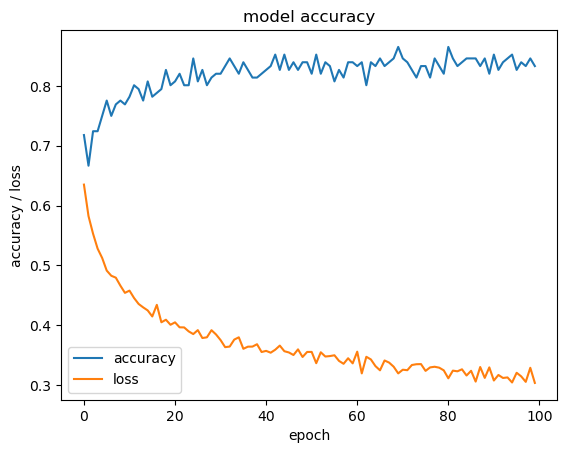

In [191]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['loss'])
plt.title('model accuracy')
plt.legend(["accuracy", "loss"])
plt.ylabel('accuracy / loss')
plt.xlabel('epoch')
plt.show()

In [192]:
model.evaluate(xTest, yTest)

2/2 [==============================] - 0s 6ms/step - loss: 0.8656 - accuracy: 0.7692 - precision: 0.6667 - recall: 0.7143 - true_positives: 10.0000 - true_negatives: 20.0000 - false_positives: 5.0000 - false_negatives: 4.0000


[0.8655775785446167,
 0.7692307829856873,
 0.6666666865348816,
 0.7142857313156128,
 10.0,
 20.0,
 5.0,
 4.0]

In [143]:
from sklearn.model_selection import KFold

In [144]:
X = df.iloc[:, :-1]
Y = df.iloc[:, -1]

In [145]:
i=0
scores = []
for train_index, test_index in list(KFold(n_splits=3).split(X,Y)):
    i+=1
    print("Fold ", str(i))
    x_train,x_test=X.iloc[train_index],X.iloc[test_index]
    y_train,y_test=Y.iloc[train_index],Y.iloc[test_index]
   
    model=getModel()

    model.fit(x_train.astype(np.float32), y_train,epochs=300, batch_size=1, verbose=2)
    clear_output(wait=True)

    results = model.evaluate(x_test.astype(np.float32), y_test)

    scores.append(results)


2/2 [==============================] - 0s 6ms/step - loss: 1.0208 - accuracy: 0.7647 - precision: 0.7857 - recall: 0.6875 - true_positives: 11.0000 - true_negatives: 15.0000 - false_positives: 3.0000 - false_negatives: 5.0000


In [146]:
acc = [score[1] for score in scores]
print(sum(acc)/len(acc))

0.7882353067398071
